# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [1]:
%matplotlib notebook

import logging
import calendar
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
from helper import *
from austria import Austria
from ecdc import ECDC
ecdc = ECDC()
AT = Austria()
logging.basicConfig(level=logging.INFO)
plt.style.use('seaborn-darkgrid')

# df_ecdc = ecdc()
# logging.info('ECDC: \n%s', df_ecdc.columns)



## Cases

<IPython.core.display.Javascript object>


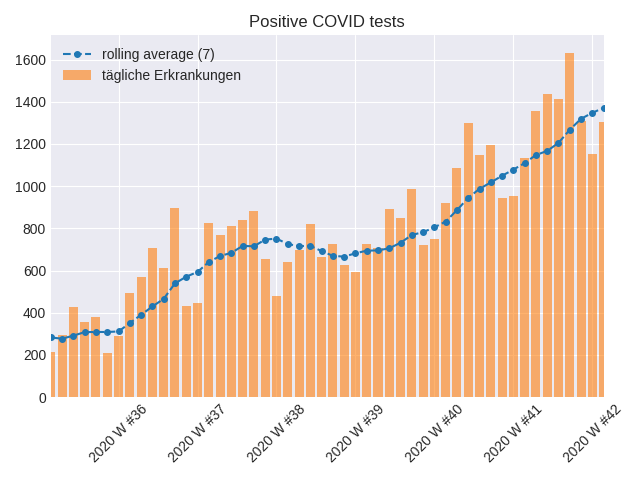

[Timestamp('2020-08-31 00:00:00'), Timestamp('2020-10-19 00:00:00')]


In [2]:
ax = AT.plot_tägliche_erkrankungen(roll_days=7,ndays=50)


In [3]:
import pandas as pd
AT.epicurve.time.max()

Timestamp('2020-10-19 00:00:00')

## Weekday Bias

<IPython.core.display.Javascript object>


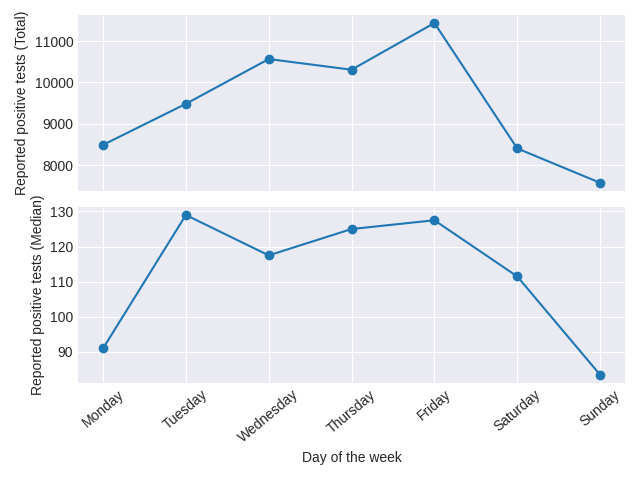

In [9]:
f, ax = plt.subplots(nrows=2, sharex=True)
AT.epicurve.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
AT.epicurve.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

## Comparison with ECDC data

### Number of cases

In [10]:
AT.epicurve['tägliche Erkrankungen'].sum(), ecdc.select_country('AT').cases.sum()


(66250, 65557)

### Plots overlaid

In [48]:
f,ax = plt.subplots()
# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax.plot(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'].rolling(7).mean(),  marker='o', markersize=4, linestyle='--', color='C1')

ax.bar(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'],label='AT',  alpha=0.6, color='C1')
selection =  ecdc.select_country('AT').sort_values(by=['year','month','day'], ascending=True)
ax.bar(selection.dateRep, selection['cases'],label='ECDC',  alpha=0.6, color='C0')
ax.plot(selection.dateRep, selection['cases'].rolling(7).mean(), marker='o', markersize=4, linestyle='--',color='C0')
# plt.yscale('log')


plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()



<IPython.core.display.Javascript object>

NameError: name 'FormatStrFormatter' is not defined

### Last 5 days

In [12]:
 ecdc.select_country('AT').sort_values('dateRep')[['dateRep', 'cases', 'deaths','popData2019', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000' ]].tail(6)

,dateRep,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
2673,2020-10-14,1171,10,8858775.0,148.496829
2672,2020-10-15,1606,9,8858775.0,153.689421
2671,2020-10-16,1396,6,8858775.0,163.081239
2670,2020-10-17,1691,7,8858775.0,172.326309
2669,2020-10-18,2040,6,8858775.0,185.985083
2668,2020-10-19,1062,3,8858775.0,191.211539


In [13]:
AT.epicurve.sort_values('time').tail(5)

,time,tägliche Erkrankungen,Timestamp,weekday
232,2020-10-14,1423,2020-10-19T14:02:01,2
233,2020-10-15,1371,2020-10-19T14:02:01,3
234,2020-10-16,1653,2020-10-19T14:02:01,4
235,2020-10-17,1334,2020-10-19T14:02:01,5
236,2020-10-18,975,2020-10-19T14:02:01,6


In [14]:
AT.epicurve.time.max()

Timestamp('2020-10-18 00:00:00')

In [15]:
AT.epicurve.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'time': ['min', 'max']} )


,tägliche Erkrankungen,time
last_7_days_sum,9244.000000,NaT
latest,975.000000,NaT
max,1653.000000,2020-10-18
min,NaN,2020-02-25
rolling_avg,1320.571429,NaT
sum,66250.000000,NaT


In [16]:
ecdc.compact_overview(ecdc.select_country('AT'))

cases              deaths                  \
                         rolling_avg latest   max    sum last_7_days_sum   
countriesAndTerritories                                                    
Austria                  1367.714286   1062  2040    910              46   

                                                
                        rolling_avg latest max  
countriesAndTerritories                         
Austria                    6.571429      3  31

## Number of Tests and Positives

### Vienna

In [6]:
wien_cases = AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien']
wien_timeline = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk=='Wien']


In [7]:
wien_cases.iloc[0].MeldeDatum

Timestamp('2020-04-01 00:00:00')

<IPython.core.display.Javascript object>


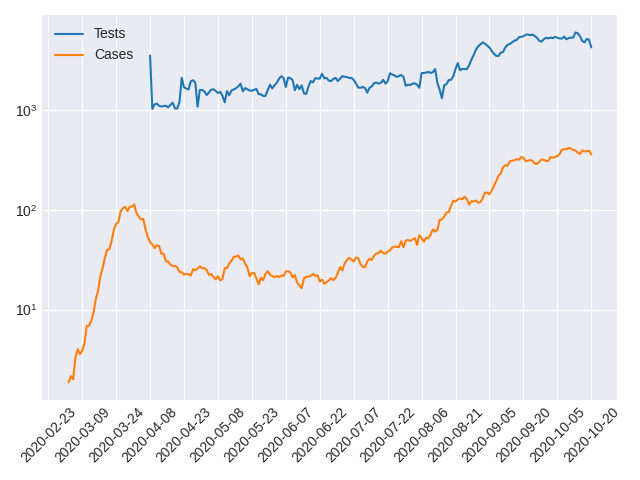

In [8]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Tests')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend(loc='best')
plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

<IPython.core.display.Javascript object>


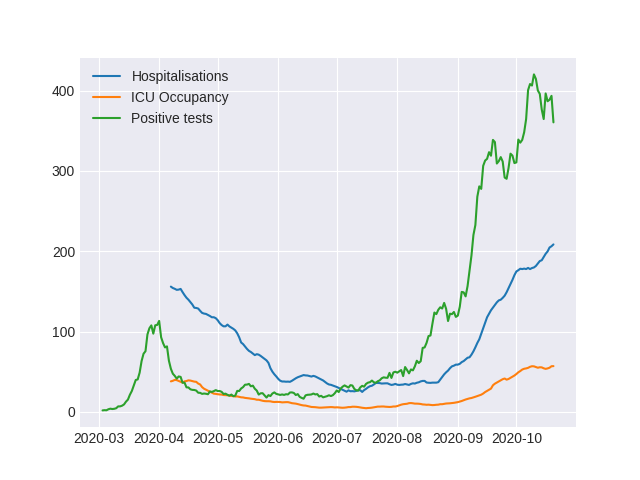

In [11]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
# ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')
# plt.yscale('log')

# ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(), label='Epicurve')
# plt.yscale('log')
plt.legend(loc='best')
#  Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
#        'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
#        'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
#        'AnzahlGeheiltSum'],

#  Index(['Meldedat', 'TestGesamt', 'MeldeDatum', 'FZHosp', 'FZICU', 'FZHospFree','FZICUFree', 'BundeslandID', 'Bundesland'],


In [12]:
AT.epicurve.columns

Index(['time', 'tägliche Erkrankungen', 'Timestamp', 'weekday'], dtype='object')

### Ratio of positives to tests

<IPython.core.display.Javascript object>


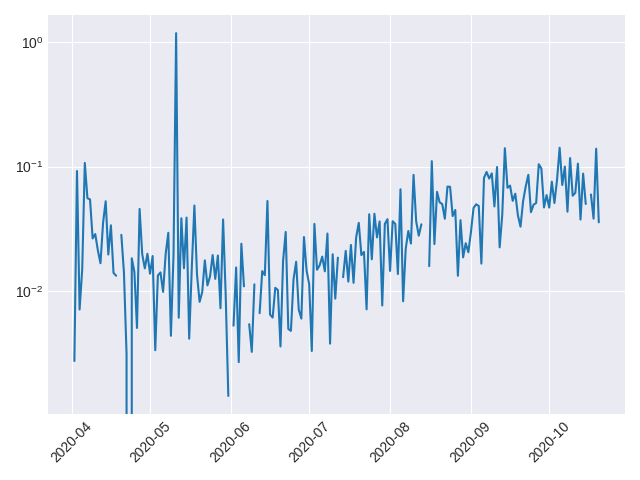

<ipython-input-15-7fe128ef3274>:6: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.array(wien_timeline[wien_timeline.Time.isin(wien_cases.MeldeDatum)].AnzahlFaelle)/np.array(wien_cases.TestGesamt.diff())


In [15]:
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
# ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
# ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')
f,ax=plt.subplots()
ratio = np.array(wien_timeline[wien_timeline.Time.isin(wien_cases.MeldeDatum)].AnzahlFaelle)/np.array(wien_cases.TestGesamt.diff())
ax.plot(wien_cases.MeldeDatum,ratio)
plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

## Corona Ampel

In [22]:
ampel = AT.ampel_aktuell

ampel.sort_values('Warnstufe', ascending=False).head(10)

,Region,GKZ,Name,Warnstufe
62,Bezirk,502,Hallein,4
80,Bezirk,701,Innsbruck-Stadt,4
82,Bezirk,703,Innsbruck-Land,4
45,Bezirk,403,Wels(Stadt),4
137,Gemeinde,80219,Hohenweiler,3
138,Gemeinde,80220,Kennelbach,3
136,Gemeinde,80218,Hörbranz,3
142,Gemeinde,80224,Lauterach,3
115,Gemeinde,80126,Thüringen,3
133,Gemeinde,80215,Hard,3


## ICU Beds

<IPython.core.display.Javascript object>


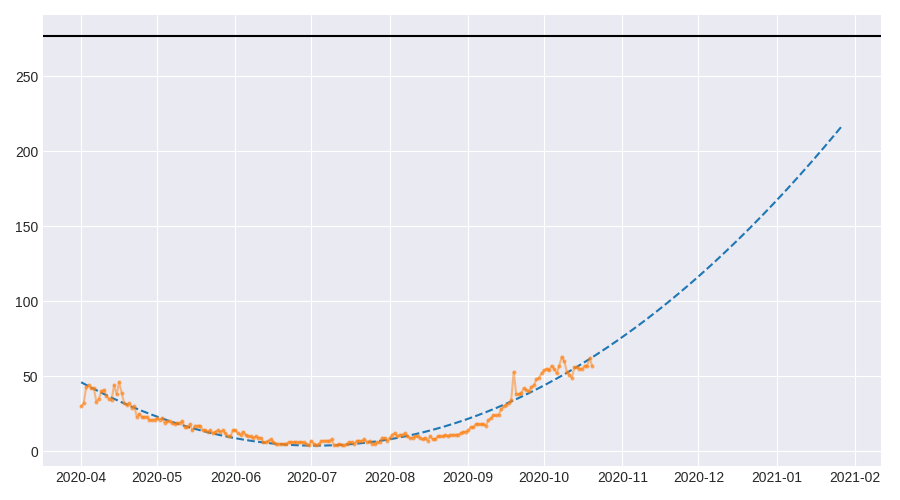

In [26]:
icu_occupancy = np.array(wien_cases.FZICU)
ndays = np.arange(len(icu_occupancy))
predict_days=100
future = np.arange(ndays[0],ndays[-1]+predict_days)
future_days = pd.date_range(start =wien_cases.iloc[0].MeldeDatum, end = wien_cases.iloc[-1].MeldeDatum + timedelta(days=predict_days-1)).to_list()

z = np.polyfit(ndays, icu_occupancy, 2)
p = np.poly1d(z)

f, ax = plt.subplots(figsize=(9,5))
ax.plot(future_days, p(future), linestyle='--')
ax.plot(wien_cases.MeldeDatum, icu_occupancy, label='occupancy', marker='o', alpha=0.5,markersize=2)
ax.axhline(y=277,color='k')

plt.tight_layout()

## Deaths

In [27]:
from gestorbene import Gestorbene
G = Gestorbene()

### Overall Deaths

<IPython.core.display.Javascript object>


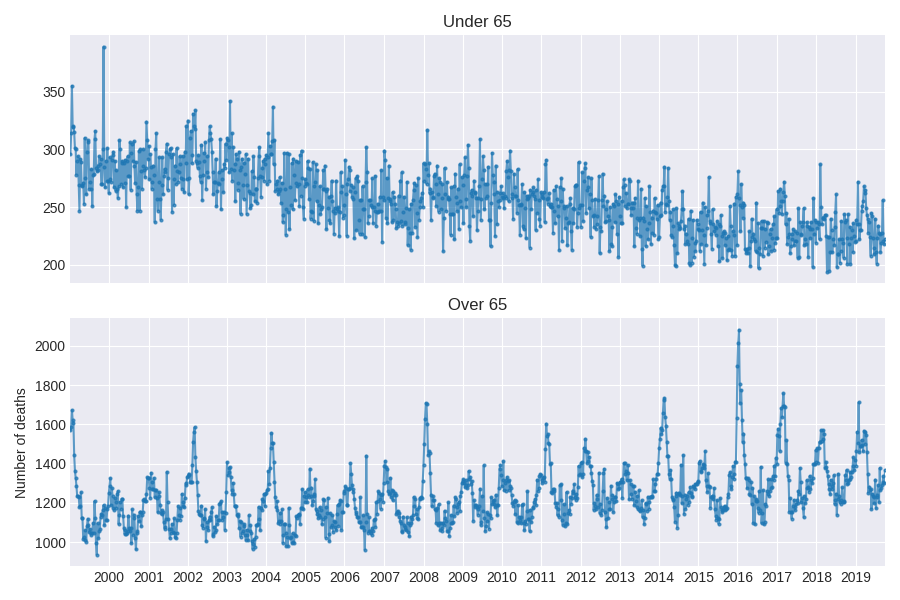

In [28]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30'],
              dtype='datetime64[ns]', length=249, freq='M')


<IPython.core.display.Javascript object>


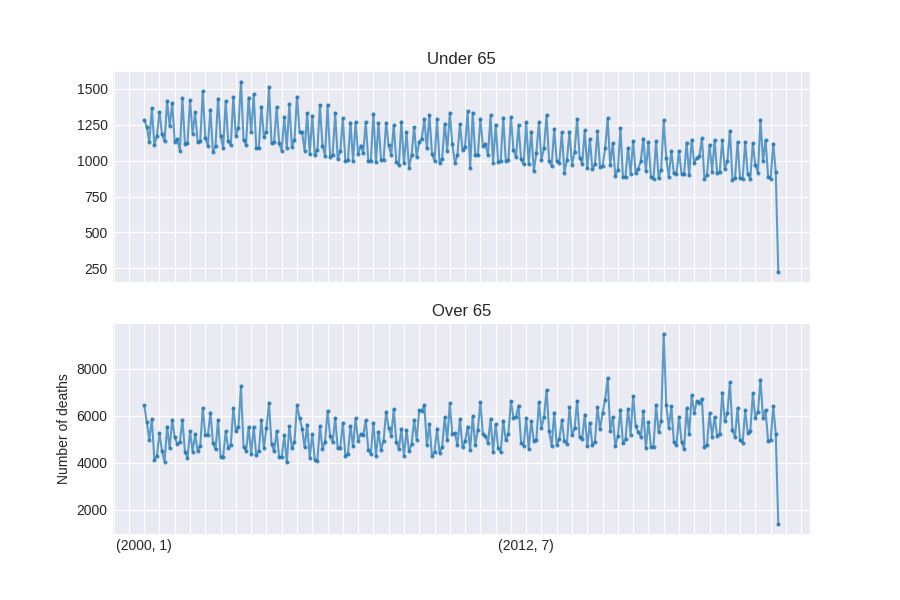

In [73]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')
print(dates)
f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(50))

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

# plt.tight_layout()

### By Gender

<IPython.core.display.Javascript object>


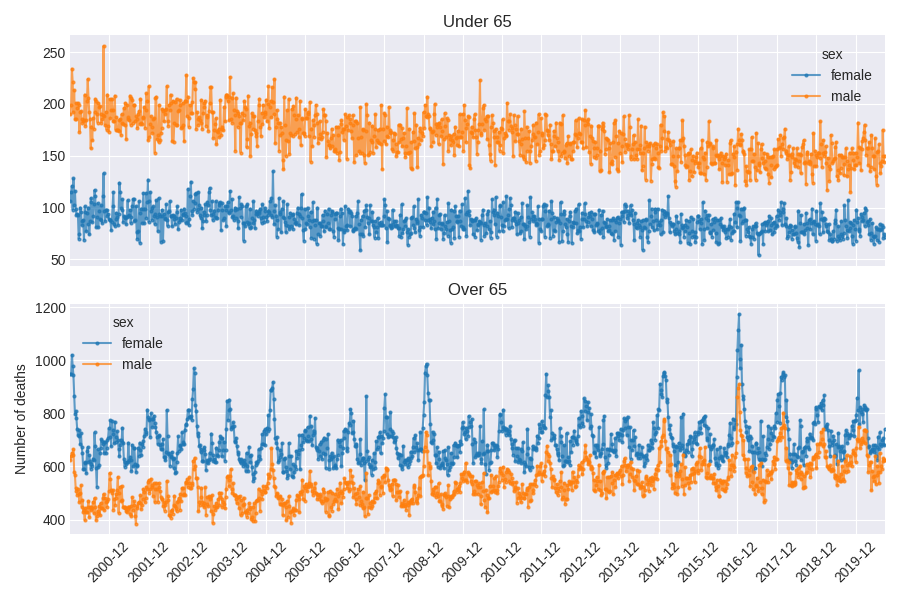

In [74]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'))
plt.tight_layout()

### Monthly